## Inspect PF-Controller Network Outputs

This notebook visualizes the outputs of the trained particle-filter (PF) controller neural network. It illustrates how the network modulates noise parameters, prior weighting, and likelihood correction terms as functions of time. The notebook is intended for inspection and diagnostic purposes and is not part of the core training or evaluation pipeline.

In [1]:
from pathlib import Path
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from src.models.particle_filter.core import ParticleFilterMLP

from experiment_config import DegModel,DATA_NAME,FILTERED_SUFFIX,PFNET_NAME,LEAKY_SLOPE, HIDDEN_DIMS

## Task

In [2]:
perform_name = 'SmLPC'

## Get netoutput names

In [3]:
state_names = DegModel.get_state_names()
netout_names = [p.replace('raw_','noise_') for p in state_names] +[p.replace('raw_','prior_') for p in state_names] +['correct_like']+['forget_like']
n_outs = len(netout_names)

In [4]:
netout_names

['noise_dmy',
 'noise_dmx',
 'noise_dmc',
 'noise_dvx',
 'noise_dvs',
 'noise_nmy',
 'noise_nvy',
 'prior_dmy',
 'prior_dmx',
 'prior_dmc',
 'prior_dvx',
 'prior_dvs',
 'prior_nmy',
 'prior_nvy',
 'correct_like',
 'forget_like']

In [5]:
DegModel.get_state_semantics()

{'raw_dmy': 'Degradation mean on performance/y-axis)',
 'raw_dmx': 'Degradation mean on time/x-axis',
 'raw_dmc': 'Degradation mean curvature exponent',
 'raw_dvx': 'Degradation variance on time/x-axis',
 'raw_dvs': 'Degradation variance slope',
 'raw_nmy': 'Nominal mean on performance/y-axis',
 'raw_nvy': 'Nominal variance on performance/y-axis'}

## Hyper-Parameters

In [6]:
activation = nn.LeakyReLU(LEAKY_SLOPE)

In [7]:
experiment_dir = Path('experiments')/DATA_NAME
degmodel_dir = experiment_dir/f'degradation{FILTERED_SUFFIX}'/DegModel.name()
pfnet_dir = degmodel_dir /'pf_performs'/PFNET_NAME

In [8]:
net = ParticleFilterMLP(state_dim=DegModel.state_dim(), hidden_dims=HIDDEN_DIMS,
                        activation=lambda : activation)

ckpt = torch.load(pfnet_dir/perform_name/'checkpoint.pt',weights_only=False)
net.load_state_dict(ckpt['model_state'])

net.eval()    # or net.train()

ParticleFilterMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=16, out_features=16, bias=True)
  )
)

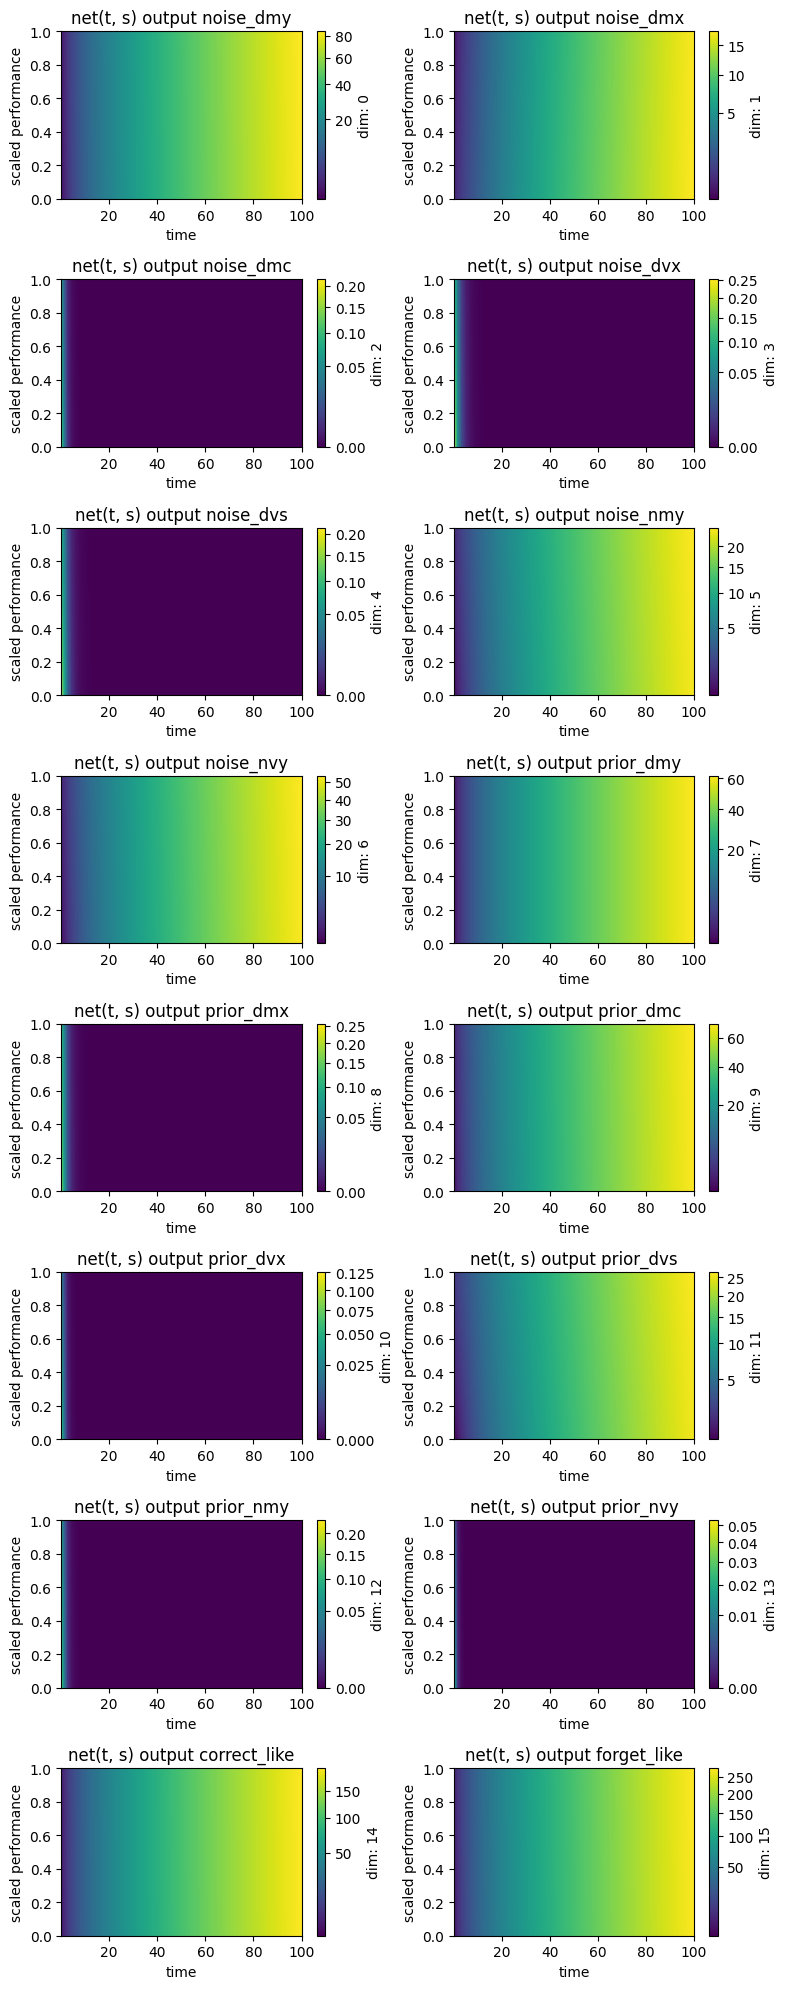

In [9]:
t_grid = np.linspace(0.1, 100, 300)
s_grid = np.linspace(0.0, 1.0, 200)

net.eval()

fig, axes = plt.subplots(math.ceil(n_outs/2), 2, figsize=(8, 20))
for i,name in enumerate(netout_names):
	net.plot_output(
		t=t_grid,
		s=s_grid,
		dim=i,
  		vmax=None,
		ax=axes[i//2, i%2],
		title=f"net(t, s) output {name}",
	)


plt.tight_layout()
plt.show()